In [62]:
from collections import Counter


In [80]:
from collections import Counter
from os import system, listdir
from os.path import join
import glob
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import string
import spacy
from collections import Counter,deque
from wordcloud import WordCloud
from wordcloud import STOPWORDS

blue_gray_cmap = LinearSegmentedColormap.from_list(
    "blue_gray",
    ["#1f4fd8", "#8e8e8e"]  # blue → gray
)

In [95]:
TEXT_PATH = "data/text.txt"
FONT_PATH = "Montserrat-SemiBold.ttf"
FONT_PATH = "Montserrat-SemiBold.ttf"
MIN_LEN = 2   # or 3 if you want to be stricter
MAX_WORDS = 100
WC_WIDTH = 4100
WC_HEIGHT = int(WC_WIDTH * 0.3)
nlp = spacy.load(
    "en_core_web_sm",
    disable=["parser", "ner"]    
)
nlp.max_length = 3_000_000   # must be > len(text)

TEXT_PATH = "data/text.txt"
def load_text(path: str) -> str:
    """Load text file and return lowercase concatenated string."""
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        return "".join(line.lower() for line in f)
# Load text
text = load_text(TEXT_PATH)


CUSTOM_STOPWORDS = {
    # Core cleanup
    "datum","network",

    # Basic noise & formatting
    "said", "et", "al", "fig", "figure", "number",
    "one", "two", "using", "use", "also", "may", "however",
    "results", "result", "data", "based", "show", "shown",
    "http", "https", "doi", "component", "free",
    "corresponding", "author", "authors",
    "rights", "reserved", "used", "case",
    "wang", "different", "effect", "effects",
    "table", "similar",

    # Generic filler words
    "work", "study", "paper", "section", "introduction", "conclusion", "article",
    "analysis", "discussion", "final", "present", "previous",
    "overall", "main", "general", "important", "significant",
    "basic", "effective", "necessary", "possible", "available",
    "actual", "original", "true", "large", "small", "output",

    # Methodology boilerplate
    "process", "procedure", "framework", "strategy", "workflow",
    "methodology", "technique", "system", "task", "operation",
    "implementation", "application", "approach",
    "design", "development",

    # Training / ML boilerplate
    "training", "validation", "batch", "epoch",
    "learning", "rate", "loss", "cost",
    "weight", "update", "gradient", "descent",

    # Evaluation & metrics
    "evaluation", "metric", "low", "high", "good", "many",
    "error", "residual", "misfit", "robustness", "robust",

    # Dataset artifacts
    "dataset", "synthetic", "simulated",
    "ground", "truth", "observation",
    "measurement", "noise", "noisy",
    "test", "sample", "scenario",

    # Math / physics generic
    "equation", "differential", "partial",
    "matrix", "vector", "calculation",
    "variable", "constant", "term",
    "space", "domain", "grid", "cell",

    # Publication metadata
    "ieee", "journal", "conference",
    "transaction", "issn", "preprint",

    # Case-study bias
    "marmousi", "salt", "borehole", "reservoir", "water",

    # Verbs, connectors, modeling boilerplate
    "apply", "obtain", "propose", "give", "require", "consider", "provide",
    "demonstrate", "indicate", "perform", "calculate", "make", "contain",
    "define", "introduce", "learn", "utilize", "describe", "produce",
    "method", "algorithm",
    "experiment", "simulation", "example",
    "input", "layer", "parameter", "value", "point", "set",
    "train", "optimizer", "objective",
    "model", "modeling", "forward",
    "image", "plot", "display",
    "will", "moreover", "although", "finally", "often", "usually",
    "km", "vs", "time", "wave", "field", "physical", "medium",
    "property", "function",
    "first", "step"
}

# Acronyms
ACRONYMS = {
    "fwi": "FWI",
    "efwi": "EFWI",
    "rtm": "RTM",
    "pinn": "PINN",
    "pinns": "PINNs",
    "cnn": "CNN",
    "dnn": "DNN",
    "rnn": "RNN",
    "gan": "GAN",
    "fno": "FNO",
    "pde": "PDE",
    "ssim": "SSIM",
    "mse": "MSE",
    "bfgs": "BFGS",
    "fga": "FGA"
}

TERM_NORMALIZATION = {
    "fouri": "fourier",
}

MIN_LEN = 3
NGRAMS = {2, 3}

WC_STOPWORDS = STOPWORDS.union(CUSTOM_STOPWORDS)

wc_terms = []
window = deque(maxlen=max(NGRAMS))

for doc in nlp.pipe((text,), batch_size=1):
    for token in doc:
        if (
            token.is_alpha
            and len(token.text) >= MIN_LEN
            and token.pos_ in {"NOUN", "ADJ"}
        ):
            lemma = token.lemma_.lower()

            if lemma in WC_STOPWORDS:
                continue

            # normalize acronyms
            term = ACRONYMS.get(lemma, lemma)
            term = TERM_NORMALIZATION.get(term, term)


            # unigram
            wc_terms.append(term)

            # n-grams
            window.append(term)
            for n in NGRAMS:
                if len(window) >= n:
                    wc_terms.append(" ".join(list(window)[-n:]))

        else:
            window.clear()

# Count terms
counter = Counter(wc_terms)

# Filter weak n-grams
counter = Counter({
    k: v for k, v in counter.items()
    if " " not in k or v >= 5
})

 

In [96]:
OUTPUT_TXT = "wc_terms_frequency.txt"

with open(OUTPUT_TXT, "w", encoding="utf-8") as f:
    f.write("term\tfrequency\n")
    for term, freq in counter.most_common():
        f.write(f"{term}\t{freq}\n")

In [97]:
# WordCloud generation
wc = WordCloud(
    font_path=FONT_PATH,
    background_color="white",
    colormap=blue_gray_cmap,
    prefer_horizontal=0.7,
    max_words=MAX_WORDS,
    width=WC_WIDTH,
    height=WC_HEIGHT,
    random_state=1,
    min_font_size=10,
    max_font_size=200,
)

wc.generate(wc_text)

# Tokenize cleaned text
tokens = wc_text.split()

# Raw frequencies
counter = Counter(tokens)
counter = Counter(dict(counter.most_common(MAX_WORDS)))

# Total number of tokens
total = sum(counter.values())

# Normalized frequencies
normalized_freq = {
    word: freq / total
    for word, freq in counter.items()
}
 

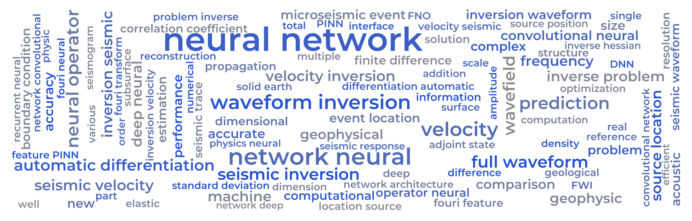

In [98]:
# Plot
plt.figure(figsize=(7.0, (7.0*0.3)), constrained_layout=True)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig("figs/wordcloud.svg", dpi=300)
plt.show()


# Save outputs
with open("data/included_words.txt", "w") as f:
    f.write(",".join(wc.words_.keys()))

with open("data/included_words_with_relevance.txt", "w") as f:
    f.write("word,relevance\n")
    for w, v in sorted(wc.words_.items(), key=lambda x: x[1], reverse=True):
        f.write(f"{w},{v:.6f}\n")


In [88]:
from collections import Counter

# Tokens already filtered (NOUNS + ADJS + stopwords removed)
tokens = wc_text.split()

counter = Counter(tokens)

print(f"Total unique words: {len(counter)}\n")

print("Top considered words:\n")
for word, freq in counter.most_common(50):
    print(f"{word:<25} {freq}")

Total unique words: 5332

Top considered words:

network                   3699
seismic                   3678
velocity                  3185
neural                    2832
inversion                 2370
source                    1502
deep                      1354
frequency                 1197
problem                   1137
wavefield                 944
waveform                  937
location                  834
prediction                821
elastic                   772
operator                  754
full                      744
receiver                  710
regression                682
accuracy                  678
inverse                   626
solution                  617
propagation               609
feature                   604
event                     580
fouri                     578
convolutional             551
computational             549
surrogate                 532
geophysical               522
difference                513
structure                 511
acoustic    